# Notebook for exploring optoidentified units

### install and import essential packages and data

In [1]:
import scipy as sp
import scipy.io
import scipy.stats
import os
import numpy as np
import pandas as pd
import glob
import csv
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as mpl

%load_ext autoreload

In [2]:
%cd C:/Users/PC/Documents/GitHub/Claustrum_analysis/Files for Eric/


C:\Users\PC\Documents\GitHub\Claustrum_analysis\Files for Eric


In [3]:
task_data_files = glob.glob("Log_Cl*")
opto_data_files = glob.glob("Opto_log_Cl*")
opto_spike_files = glob.glob("optoSpikes_log_Cl*")
opto_wave_files = glob.glob("waveform_log_Cl*")

column_names1 =['mouse_name', 'date','block_type', 'trial_type', 'touch_stimulus',
                'vis_stimulus', 'response', 'trial_num', 'stim_onset', 'stim_offset', 
                'licks_right', 'licks_left', 'spike_times', 'cluster_name' ]
column_names2 = ['mouse_name', 'date', 'cluster_name', 'opto_stim_onsets','opto_stim_offsets']
column_names3 = np.concatenate((['mouse_name', 'date', 'cluster_name', 'spikes'],
                                ['waveform_'+str(i) for i in range(128)]))

log_df = pd.DataFrame([], columns = column_names1)
opto_log_df = pd.DataFrame([], columns = column_names2)
opto_spikes_df = pd.DataFrame()
opto_waves_df = pd.DataFrame()


for file_num in tnrange(len(glob.glob("Log_Cl*"))):
    mat = sp.io.loadmat(task_data_files[file_num])
    mat2 = sp.io.loadmat(opto_data_files[file_num])
    
    log = mat['log']
    log2 = mat2['optoTable']

    indv_log_df = pd.DataFrame(log, columns = column_names1)

    log_df = pd.concat([log_df,indv_log_df])
    opto_log_df = pd.concat([opto_log_df,pd.DataFrame(log2, columns = column_names2)])

for fn in range(len(opto_spike_files)):
    opto_waves_df = pd.concat([opto_waves_df, pd.read_csv(opto_wave_files[fn])])
    opto_spikes_df = pd.concat([opto_spikes_df, pd.read_csv(opto_spike_files[fn])])

opto_log_df = opto_log_df.reset_index(drop = True) 
opto_spikes_df = opto_spikes_df.reset_index(drop = True)

##spikes/waves were listed in opto_waves_df by finding all spikes within 0.025s of laser pulse
##this can cause spikes to be listed more than once when frequency of laser stim was >50hz
##This will remove double listed spikes:
opto_waves_df = opto_waves_df.drop_duplicates().reset_index(drop = True)
                     

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [4]:
for col in [0,1,2,3,4,5,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,11,11,13]:
        log_df.iloc[:,col] = log_df.iloc[:,col].str[0]
for col in [0,1,2,3,4]:
        opto_log_df.iloc[:,col] = opto_log_df.iloc[:,col].str[0]
opto_spikes_df['cluster_name'] = opto_spikes_df['cluster_name'].apply(lambda y: 'T'+ y)
opto_waves_df['cluster_name'] = opto_waves_df['cluster_name'].apply(lambda y: 'T'+ y)

In [5]:
# log_df['licks_right'] = log_df['licks_right'].apply(lambda y: [y[i] for i in range(len(y))])
# log_df['licks_left'] = log_df['licks_left'].apply(lambda y: [y[i] for i in range(len(y))])
log_df['stim_onset'] = log_df['stim_onset'].fillna(0)
log_df['spike_times(stim_aligned)'] = log_df['spike_times'] - log_df['stim_onset']
licks = pd.concat([log_df['licks_right'] - log_df['stim_onset'] , log_df['licks_left']-log_df['stim_onset']], axis=1)
licks = licks.applymap(lambda y: y[[0.1<y]] if len(y) > 0 else y)
licks = licks.applymap(lambda y: y[[3>=y]] if len(y) > 0 else y)
first_licks = licks.applymap(lambda y: min(y) if len(y) > 0 else np.nan)
last_licks = licks.applymap(lambda y: max(y) if len(y) > 0 else np.nan)

log_df['first_lick'] = first_licks.min(axis=1)
log_df['last_lick'] = last_licks.max(axis=1)
log_df['spike_times(lick_aligned)'] = log_df['spike_times'] - (log_df['first_lick'].fillna(2)+log_df['stim_onset'])
log_df['spike_times(last_lick_aligned)'] = log_df['spike_times'] - (log_df['last_lick'].fillna(2)+log_df['stim_onset'])


log_df[['licks_right','licks_left', 'spike_times(stim_aligned)','spike_times(lick_aligned)']] = \
log_df[['licks_right','licks_left', 'spike_times(stim_aligned)',
        'spike_times(lick_aligned)']].applymap(lambda x: np.concatenate(x) if len(list(x)) > 0 else x)

log_df = log_df.sort_values(['mouse_name', 'date', 'cluster_name', 'first_lick'], ascending = [1,1,1,1])
log_df['identified'] = 'unidentified'
log_df = log_df.reset_index(drop=True)

In [6]:
unique_sessions = opto_log_df[['mouse_name', 'date']].drop_duplicates().reset_index(drop = True)

opto_log_df['first_last_opto_pulses'] = np.nan
opto_log_df['grouped_opto_pulses'] = np.nan

for session in tnrange(unique_sessions.shape[0]):
    
    session_row_ind = (opto_log_df.loc[:,['mouse_name', 'date']] == unique_sessions.iloc[session]).all(axis=1)
    rows = opto_log_df.loc[session_row_ind]
    
    ISIs = np.around(rows.iloc[0,3][1:]-rows.iloc[0,3][0:-1], 4)
    if len(ISIs) == 0:
        continue
    ISIs = np.concatenate(([ISIs[0]], ISIs, [ISIs[-1]]))
    unique_ISIs = np.unique(ISIs, return_counts = True)
    ind = unique_ISIs[1]>50
    unique_ISIs = unique_ISIs[0][ind]

    first_last_opto_pulses = {}
    grouped_opto_pulses = {}
    for isi in unique_ISIs:
        ISI_category = np.where(np.absolute(ISIs-isi) <= 0.001)[0]
        last_ind = np.where(np.diff(ISI_category) > 30)
        last_ind = last_ind[0]
        if last_ind.size ==0:
            last_ind = ISI_category[-1]
        opto_pulse_inds= np.array(range(np.min(ISI_category),last_ind))
        grouped_opto_pulses[1/isi] = rows.iloc[0,3][opto_pulse_inds]

        IBI_ind = ISIs[opto_pulse_inds] != isi
        first_pulse_ind = np.concatenate(([opto_pulse_inds[0]],opto_pulse_inds[IBI_ind]))
        last_pulse_ind = np.concatenate((first_pulse_ind[1:]-1, [opto_pulse_inds[-1]]))
        first_last_opto_pulses[1/isi] = [rows.iloc[0,3][first_pulse_ind],rows.iloc[0,3][last_pulse_ind]]
    opto_log_df.loc[session_row_ind,'first_last_opto_pulses'] = [first_last_opto_pulses]
    opto_log_df.loc[session_row_ind,'grouped_opto_pulses'] = [grouped_opto_pulses]

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [7]:
opto_log_df[['mouse_name', 'date']].drop_duplicates()

,mouse_name,date
0,Cl4,05-19-17
25,Cl4,05-23-17
48,Cl4,05-24-17
73,Cl4,05-26-17
100,Cl4,05-31-17
117,Cl4,06-02-17
143,Cl4,06-03-17
161,Cl4,06-05-17
203,Cl4,06-08-17
227,Cl4,06-09-17


### plot spike rasters for optogenetic stimulus trials
#### define function that will plot rasters

In [8]:
import matplotlib.patches as patches
from matplotlib import gridspec
# font = {'family' : 'sans-serif',
#         'weight' : 'normal',
#         'size'   : 18}

# mpl.rc('font', **font)
# mpl.rc('xtick', labelsize=16) 
# mpl.rc('ytick', labelsize=16)
# mpl.rc('axes', labelsize=18)


def opto_identify(unit_num, log_df, opto_log_df, opto_spikes_df):

    unit = opto_log_df.iloc[unit_num]
    unit_indices = (unit[['mouse_name','date','cluster_name']] ==
                    opto_spikes_df[['mouse_name','date','cluster_name']]).all(axis = 1)
    unit_spikes = opto_spikes_df.loc[unit_indices, 'spikes']

    mpl.close('all')
    frequencies = np.array(list(unit['first_last_opto_pulses'].keys()))
    frequencies = frequencies[frequencies != 2]

    fig = mpl.figure(figsize=(10, 20))
    fig.suptitle(unit['mouse_name'] + ', ' +  unit['date'] + ', ' + unit['cluster_name'])
    gs = gridspec.GridSpec(11, 1, height_ratios=[1, 15, 5, 1, 15, 5, 1, 15, 5, 1, 15])

#     rs1 = fig.add_subplot(gs[2])
#     rs2 = fig.add_subplot(gs[3])
#     rs3 = fig.add_subplot(gs[8])
#     rs4 = fig.add_subplot(gs[9])
    
#     ax1 = fig.add_subplot(gs[0], sharex = rs1)
#     ax2 = fig.add_subplot(gs[1], sharex = rs2)
#     ax3 = fig.add_subplot(gs[6], sharex = rs3)
#     ax4 = fig.add_subplot(gs[7], sharex = rs4)

#     rasters = [rs1, rs2, rs3, rs4]
#     opto_axes = [ax1, ax2, ax3, ax4]
    raster_positions = [1,4,7,10]
    stim_fig_positions = [0,3,6,9]

    for i, frequency in enumerate(frequencies):
        
        raster = fig.add_subplot(gs[raster_positions[i]])
        stim_fig = fig.add_subplot(gs[stim_fig_positions[i]], sharex = raster)
        
        flop = unit['first_last_opto_pulses'][frequency]

        trial_dur = flop[1][0] - flop[0][0]
        trial_total = 0
        for trial in range(len(flop[0])):
            trial_spike_inds = (flop[0][trial]-0.5 < unit_spikes) & (unit_spikes < flop[0][trial] + trial_dur + .5)
            trial_spikes = unit_spikes[trial_spike_inds] - flop[0][trial]
            raster.vlines(trial_spikes, trial + .5, trial + 1.3, linewidth = 0.5)
            trial_total += 1

        figure_pulse_inds = [(unit['grouped_opto_pulses'][frequency] >= flop[0][-1])
                  & (unit['grouped_opto_pulses'][frequency] <= flop[1][-1])]
        figure_pulses = unit['grouped_opto_pulses'][frequency][figure_pulse_inds] - flop[0][-1]
        example_pulse_ind = np.where(unit['opto_stim_onsets'] == flop[0][-1])
        stim_duration = unit['opto_stim_offsets'][example_pulse_ind] - unit['opto_stim_onsets'][example_pulse_ind]

        for p in figure_pulses:
            stim_fig.add_patch(patches.Rectangle((p,0), stim_duration, 4, color = '#3182bd')) 

        raster.autoscale(enable=True, tight=True)
        raster.spines['right'].set_visible(False)
        raster.spines['top'].set_visible(False)
        raster.xaxis.set_ticks_position('bottom')
        raster.yaxis.set_ticks_position('left')
        raster.set_xlabel('Time(s)')
        raster.set_ylabel('Trials')

        stim_fig.set_ylim(0, 4,)
        stim_fig.set_xlim(-0.5, trial_dur + 0.5)
        stim_fig.axis('off')
        stim_fig.set_title(str(frequency) + ' Hz')

    mpl.subplots_adjust(left=0.1, right=.9, top=0.9, bottom=0.1)
    fig
    return fig

#### create widget that will make exploring data easier - drag slider to switch between units

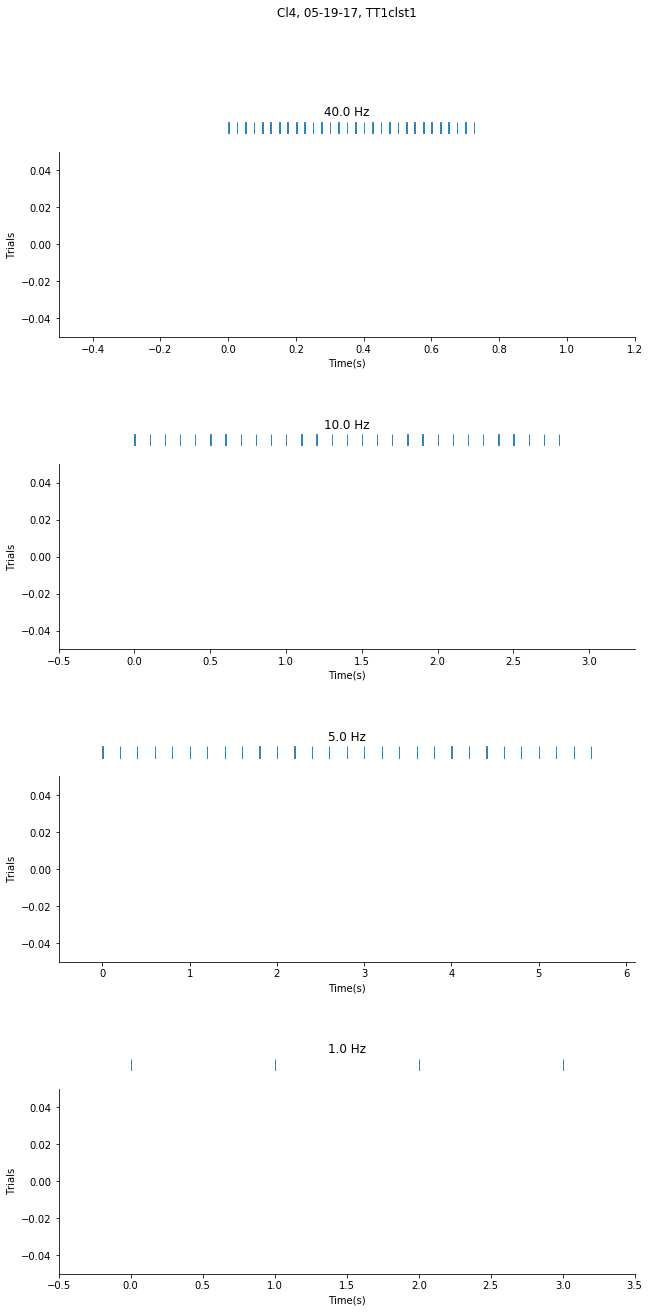

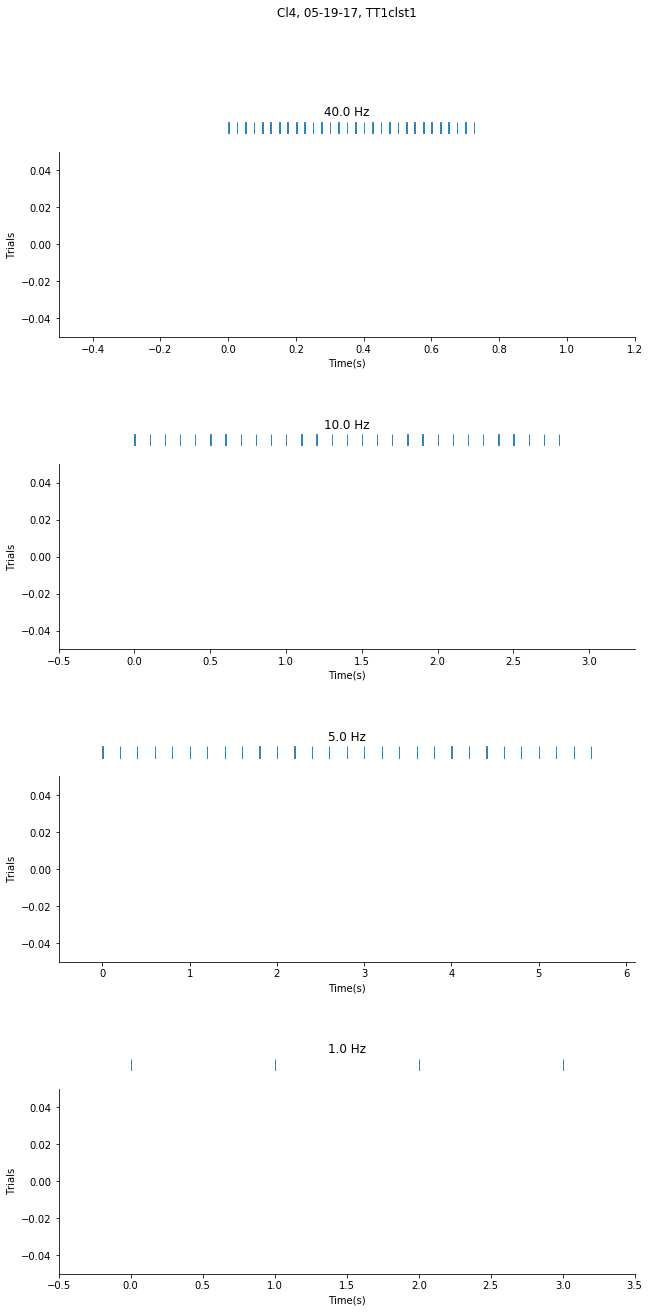

In [9]:
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.html import widgets
from IPython.display import display
import traitlets

num = widgets.IntSlider(min = 0, max = opto_log_df.shape[0], step = 1, width='75%', height='30px', 
                    description= "Unit", continuous_update=False)
s = interactive(opto_identify, unit_num = num, log_df = fixed(log_df),
                opto_log_df = fixed(opto_log_df), opto_spikes_df = fixed(opto_spikes_df),
                continuous_update=False)
s

In [ ]:
mpl.savefig('opto_example2.pdf',format='pdf', dpi=1200)

### plot reliability and latency of optogenetic responses
#### calculate identification metrics for each unit

In [10]:
def find_latencies(frequency_row):
    ## defines the latencies of spikes by first defining a window around the peak of
    ## first spike histogram. Spike latencies are only considered if the spike lands
    ## within that window. Abscence of spikes within the window will degrade reliability.
    spikes = unit_spikes.as_matrix()
    pulse_bins = [np.arange(pulse, pulse+0.020, 0.001)[:20] for pulse in frequency_row['pulses']] # 1 ms bins
    hist = np.mean([np.histogram(spikes, pulse)[0] for i, pulse in enumerate(pulse_bins)], axis = 0)

    # look for spikes within +/- 3 bins (3 ms) of mean latency bin 
    mean_biggest_bins = np.convolve(hist, np.ones((3,))/3, mode='same').argsort()[-1:][0] #finds middle of largest 3 consecutive bins
    window_template = [[mean_biggest_bins - 3, mean_biggest_bins + 3] if 19-3 >= mean_biggest_bins >= 3 
                       else [0, mean_biggest_bins + 3] if mean_biggest_bins <= 19-3 
                       else [mean_biggest_bins - 3, 19]][0]
    window_starts = [pulse[window_template[0]] for pulse in pulse_bins]
    window_ends = [pulse[window_template[1]] for pulse in pulse_bins]
    latency_bin_start = window_template[0] #number of ms (1ms = 1bin) after pulse where spikes are considered 'laser evoked'

    idx = spikes.searchsorted(window_starts, side = 'right')
    idx2 = idx[idx < len(unit_spikes)] #otherwise will return an error if no spikes follow the last laser pulse
    evoked_spikes = np.array([spike if spike <= window_ends[i] else np.nan for i,spike in enumerate(spikes[idx2])])
    latencies = np.array([spike - frequency_row['pulses'][i] if spike <= window_ends[i] else np.nan
                 for i,spike in enumerate(spikes[idx2])])
    reliability = [np.count_nonzero(~np.isnan(latencies))/len(latencies) if len(latencies) > 0 else 0]
    latencies = latencies[~np.isnan(latencies)]
    evoked_spikes = evoked_spikes[~np.isnan(evoked_spikes)]
    return [[evoked_spikes], [latencies], latency_bin_start,  reliability]

In [11]:
all_opto_metrics_df = pd.DataFrame()

In [12]:
opto_spikes_df['mouse_name'] = opto_spikes_df['mouse_name'].apply(lambda x: x[0:2]+x[-1])
opto_waves_df['mouse_name'] = opto_waves_df['mouse_name'].apply(lambda x: x[0:2]+x[-1])
opto_waves_df.head()

,mouse_name,date,cluster_name,spikes,waveform,waveform_1,waveform_2,waveform_3,waveform_4,waveform_5,...,waveform_118,waveform_119,waveform_120,waveform_121,waveform_122,waveform_123,waveform_124,waveform_125,waveform_126,waveform_127
0,Cl4,05-19-17,TT1clst1,2608.887,0.016397,0.016038,0.025751,0.030404,0.037678,0.052518,...,-0.024296,-0.003674,0.027822,0.043162,0.056165,0.069919,0.087798,0.082750,0.063979,0.034249
1,Cl4,05-19-17,TT1clst1,2609.837,0.023712,0.011623,0.029752,0.045814,0.057352,0.068438,...,-0.022622,-0.017166,-0.017338,-0.018293,-0.010310,0.009705,0.013159,0.033273,0.060074,0.065644
2,Cl4,05-19-17,TT1clst1,2611.225,0.019113,0.018650,0.033933,0.037065,0.035144,0.058668,...,-0.028105,-0.012151,0.003024,0.007543,0.005765,0.020378,0.023372,0.018613,0.027906,0.037371
3,Cl4,05-19-17,TT1clst1,2612.333,0.013304,0.015482,0.025595,0.041869,0.045757,0.038305,...,-0.048994,-0.037505,-0.021522,-0.012672,-0.002691,0.016396,0.026435,0.025745,0.042576,0.045603
4,Cl4,05-19-17,TT1clst1,2612.757,0.011026,0.004382,0.006441,0.009677,0.030646,0.039879,...,-0.042891,-0.047367,-0.031710,-0.004030,0.012455,0.028945,0.039967,0.033122,0.026035,0.033405


In [15]:
# this will create a dataframe containing all the important metrics to determine 
# which units are opto identified
missing_sessions = []
for row in tnrange(opto_log_df.shape[0]):
    unit = opto_log_df.iloc[row,:]
    
    if all_opto_metrics_df.shape[0] != 0:
        if (unit[['mouse_name','date','cluster_name']] == 
            all_opto_metrics_df[['mouse_name','date','cluster_name']]).all(axis = 1).any():
            continue
            
    df1 = unit[['mouse_name','date','cluster_name']]
    df2 = opto_spikes_df[['mouse_name','date','cluster_name']]
    df3 =  opto_waves_df[['mouse_name','date','cluster_name']]
    
    unit_spike_indices = pd.eval('df1 == df2').all(axis = 1)
    unit_wave_indices = pd.eval('df1 == df3').all(axis = 1) #faster comparisons using pd.eval()
    
    if not any(unit_wave_indices):
        missing_sessions.append([unit[['mouse_name', 'date']].as_matrix()])
        continue

    unit_spikes = opto_spikes_df.loc[unit_spike_indices, 'spikes'].reset_index(drop = True)
    unit_waves = opto_waves_df.loc[unit_wave_indices, :].reset_index(drop = True)

    ## create a small df to encapsulate all the data for this unit, fill in all the
    ## identifying information for the unit. Create rows for data pertaining to each
    ## optogenetic stimulus frequency given
    
    if len(unit['opto_stim_onsets']) == 0:
        
        frequencies = np.array([1,5,10,40])   
        opto_metrics_df= pd.DataFrame(frequencies, columns = ['frequency'])
        opto_metrics_df['unit_number'] = row
        opto_metrics_df['mouse_name'] = unit['mouse_name']
        opto_metrics_df['date'] = unit['date']
        opto_metrics_df['cluster_name'] = unit['cluster_name']
        opto_metrics_df['evoked_spikes'] = np.nan
        opto_metrics_df['reliability'] = np.nan
        opto_metrics_df['latencies'] = np.nan
        opto_metrics_df['mean_latencies'] = np.nan
        opto_metrics_df['latency_bin_starts']= np.nan
        opto_metrics_df['all_spikes'] = np.nan
        opto_metrics_df['control_spikes'] = np.nan
        opto_metrics_df['waveform_corr'] = np.nan
        opto_metrics_df['mean_cont_waveform1'] = np.nan
        opto_metrics_df['mean_cont_waveform2'] = np.nan
        opto_metrics_df['mean_cont_waveform3'] = np.nan
        opto_metrics_df['mean_cont_waveform4'] = np.nan
        opto_metrics_df['mean_evoked_waveform1'] = np.nan
        opto_metrics_df['mean_evoked_waveform2'] = np.nan
        opto_metrics_df['mean_evoked_waveform3'] = np.nan
        opto_metrics_df['mean_evoked_waveform4'] = np.nan
    
    frequencies = np.array(list(unit['grouped_opto_pulses'].keys()))
    frequencies = frequencies[frequencies != 2]

    opto_metrics_df= pd.DataFrame(frequencies, columns = ['frequency'])
    opto_metrics_df['unit_number'] = row
    opto_metrics_df['mouse_name'] = unit['mouse_name']
    opto_metrics_df['date'] = unit['date']
    opto_metrics_df['cluster_name'] = unit['cluster_name']

    ## select the times of all the optogenetic stimuli
    first_pulse = np.min(np.concatenate(list(unit['grouped_opto_pulses'].values())))
    last_pulse = np.max(np.concatenate(list(unit['grouped_opto_pulses'].values())))
    pulses = pd.DataFrame([[unit['grouped_opto_pulses'][freq]] for freq in frequencies],
                  columns = ['pulses'])
    opto_metrics_df['pulses'] = pulses

    ## create columns listing all spikes that occured around the time of the optogenetic
    ## stimuli presentations (for plotting rasters), 
    # %timeit evoked_spike_df = opto_windows_df.applymap(lambda y: unit_spikes[(y <= unit_spikes) & (y+0.01>= unit_spikes)].as_matrix())

    all_spikes = {}
    control_spikes = {}
    for i, freq in enumerate(frequencies):
        control_spikes[i] = unit_waves['spikes'][unit_waves['spikes'] <= first_pulse]
        all_spikes[i] = np.array(unit_spikes[(opto_metrics_df.loc[i, 'pulses'][0]-1 < unit_spikes) &
                                             (opto_metrics_df.loc[i, 'pulses'][-1]+1 > unit_spikes)])
        opto_metrics_df['all_spikes'] = pd.Series(all_spikes)
        opto_metrics_df['control_spikes'] = pd.Series(all_spikes)


    ## list the latencies of the first spike that occured following each laser stimulus 
    latency_metrics = opto_metrics_df.apply(lambda y: find_latencies(y), axis = 1) #find_latencies function defined above
    opto_metrics_df['evoked_spikes'] = [latency_metrics[i][0][0] for i in range(len(latency_metrics))]
    opto_metrics_df['reliability'] = [latency_metrics[i][3][0] for i in range(len(latency_metrics))]
    opto_metrics_df['latencies'] = [latency_metrics[i][1][0] for i in range(len(latency_metrics))]
    opto_metrics_df['mean_latencies'] = opto_metrics_df['latencies'].apply(lambda y: np.mean(y) if len(y)>0 else None)
    opto_metrics_df['latency_bin_starts']= [latency_metrics[i][2] for i in range(len(latency_metrics))]

    #calculate FR mean and std for Z-scores
    #all sessions have 10Hz stim- will use 1 sec before first pulse of each 10hz laser train as baseline period
    post_pulse_z_scores = {}
    for i, freq in enumerate(frequencies):
        bin_size = 0.010
        baseline_window_size = [1.5 if freq != 5 else 0.5]
        flop = unit['first_last_opto_pulses'][freq]
        baseline_bin_starts = flop[0]-baseline_window_size
        baseline_psth = np.mean([np.histogram(unit_spikes, np.arange(start,start+1.5, bin_size))[0]
                                 for start in baseline_bin_starts], axis = 0)/bin_size
        baseline_mean_std = [np.mean(baseline_psth), np.std(baseline_psth)]
        all_pulses_in_freq = unit['grouped_opto_pulses'][freq]
        latency_bin_starts = opto_metrics_df['latency_bin_starts'][i]
        test_bin_starts = [all_pulses_in_freq[(all_pulses_in_freq  >= flop[0][trial]) 
                                             & (all_pulses_in_freq  <= flop[1][trial])] + latency_bin_starts
                           for trial in range(len(flop[0]))]
        test_bin_starts = pd.DataFrame([window[0:10] for window in test_bin_starts]) #just looking at first 10 pulses of each trial
        ##6ms window defined in find_latency():
        test_bin_spike_counts = test_bin_starts.applymap(lambda y:
                                                         np.count_nonzero((unit_spikes >= y) 
                                                                          & (unit_spikes < y+0.006))) 
        post_pulse_z_scores[i] = (((test_bin_spike_counts.mean(axis = 0)/bin_size) 
                                   - baseline_mean_std[0])/baseline_mean_std[1]).as_matrix()
    opto_metrics_df['post_pulse_zScores'] = pd.Series(post_pulse_z_scores)

    all_evoked_spikes = np.concatenate(opto_metrics_df['evoked_spikes'].as_matrix())

    f2 = (lambda y: np.any(np.absolute(all_evoked_spikes-y) < 0.001))
    f2v = np.vectorize(f2)
    evoked_wave_ind = np.where(f2v(unit_waves['spikes']))[0]
    control_wave_ind = np.where(unit_waves['spikes'] <= first_pulse)[0]

    avg_control_wave = unit_waves.iloc[control_wave_ind, 4:].mean(axis = 0)
    avg_evoked_wave = unit_waves.iloc[evoked_wave_ind, 4:].mean(axis = 0)

    waveform_corr = [sp.stats.pearsonr(avg_control_wave, avg_evoked_wave)][0][0]
    opto_metrics_df['waveform_corr'] = np.around(pd.Series([waveform_corr]*4),2)

    opto_metrics_df['mean_cont_waveform1'] = pd.Series([avg_control_wave[0:32].as_matrix()]*4)
    opto_metrics_df['mean_cont_waveform2'] = pd.Series([avg_control_wave[32:64].as_matrix()]*4)
    opto_metrics_df['mean_cont_waveform3'] = pd.Series([avg_control_wave[64:96].as_matrix()]*4)
    opto_metrics_df['mean_cont_waveform4'] = pd.Series([avg_control_wave[96:].as_matrix()]*4)
    opto_metrics_df['mean_evoked_waveform1'] = pd.Series([avg_evoked_wave[0:32].as_matrix()]*4)
    opto_metrics_df['mean_evoked_waveform2'] = pd.Series([avg_evoked_wave[32:64].as_matrix()]*4)
    opto_metrics_df['mean_evoked_waveform3'] = pd.Series([avg_evoked_wave[64:96].as_matrix()]*4)
    opto_metrics_df['mean_evoked_waveform4'] = pd.Series([avg_evoked_wave[96:].as_matrix()]*4)


    # Finally concatenate to the larger dataframe
    if all_opto_metrics_df is None: 
        all_opto_metrics_df = opto_metrics_df
    else:
        all_opto_metrics_df = all_opto_metrics_df.append(opto_metrics_df)
    all_opto_metrics_df = all_opto_metrics_df.reset_index(drop = True)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


C:\Users\PC\Anaconda3\lib\site-packages\scipy\stats\stats.py:5240: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


In [ ]:
# Only run if new units were added to all_opto_metrics
# all_opto_metrics_df.to_hdf('all_opto_metrics.h5', 'table')

#### define function that will plot identification metrics for each unit

In [16]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":24,"axes.labelsize":20})   
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 22}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20)
mpl.rc('axes', labelsize=20)


def opto_metrics(unit_num, log, opto_metrics_log):

    unit = opto_metrics_log[opto_metrics_log['unit_number'] == unit_num]
    sub_log_df = log.iloc[unit_num]

    frequencies = unit['frequency'].drop_duplicates()
    stim_duration = 0.002

    mpl.close('all')
    fig2 = mpl.figure(figsize=(18, 10))
    fig2.suptitle(sub_log_df['mouse_name'] + ', ' +  sub_log_df['date'] + ', ' + sub_log_df['cluster_name'])

    ax1 = mpl.subplot2grid((2,2), (0,0), rowspan=2, colspan=1)
    ax2 = mpl.subplot2grid((2,2), (0,1), rowspan=1, colspan=1)
    ax3 = mpl.subplot2grid((2,2), (1,1), rowspan=1, colspan=1)

    ax4 = fig2.add_axes([0.34, 0.425, 0.1, 0.4])
    
    fig2.subplots_adjust(wspace=.4, hspace = 0.4)

    sns.despine()

    data={}
    total_stims = 0

    laser_evoked_spike_inds = []
    values = np.array([])
    labels = np.array([])
    for ind in list(unit.index):
        opto_stims = unit.loc[ind, 'pulses']
        for stim_num in range(90):
            spike_inds = ((unit.loc[ind, 'all_spikes'] >= opto_stims[stim_num]-0.02) &
                         (unit.loc[ind, 'all_spikes'] < opto_stims[stim_num] + .03))
            spikes = (unit.loc[ind, 'all_spikes'][spike_inds] - opto_stims[stim_num])*1000
            ax1.vlines(spikes, total_stims + stim_num + .5, total_stims + stim_num + 1.3, linewidth = 2)
            x = total_stims+stim_num

        ax1.plot([0,stim_duration*1000], [total_stims+stim_num, total_stims+stim_num], color = 'k', linewidth = 3)
        ax1.text(-7.5, total_stims + stim_num/2, str(unit.loc[ind, 'frequency']) + ' Hz'),
        total_stims = total_stims + stim_num
        
            
        latency_ind = unit.loc[ind,'latencies']<=0.025
        values = np.append(values,unit.loc[ind,'latencies'][latency_ind])
        labels = np.append(labels,[unit.loc[ind,'frequency']] * len(unit.loc[ind,'latencies'][latency_ind]))
                            
    data_df = pd.DataFrame([values*1000, labels], index = ['Latency (ms)', 'Frequency (Hz)']).T
    sns.violinplot(x = 'Frequency (Hz)', y = 'Latency (ms)', data = data_df, ax=ax3, color = 'xkcd:sky blue')

    sns.pointplot(x = 'frequency', y = 'reliability', data = unit, ax=ax2, join = False, color = 'xkcd:sky blue')

    offset = 0
    waveform_corr = []
    for electrode_num in range(1,5):
        laser_evoked_waveforms_df = pd.DataFrame(np.mean(unit['mean_evoked_waveform'+str(electrode_num)]))+offset
        cont_waveforms_df = pd.DataFrame(np.mean(unit['mean_cont_waveform'+str(electrode_num)]))+offset
        ax4.plot(cont_waveforms_df, color = 'k', alpha = 0.8, linewidth = 2)
        ax4.plot(laser_evoked_waveforms_df, color = 'xkcd:sky blue',alpha = 0.8, linewidth = 3)
        offset += 0.2
    ax4.set_title('r = ' + str(unit['waveform_corr'].iloc[0]))

    ax1.set_xlabel('Time(ms)')
    ax1.set_ylabel('Stim trial')
    ax1.autoscale(enable=True, tight=True)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.yaxis.set_ticks_position('left')
    ax1.add_patch(patches.Rectangle((0,0), stim_duration*1000, total_stims, color = 'xkcd:sky blue'))
    ax1.set_xlim(-20,30)

    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Mean spike latency (ms)')
    ax3.set_ylim(0,20)
    ax3.yaxis.set_ticks(np.arange(0, 20, 2.5))

    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('P(spike)')
    ax2.set_ylim(0,1)

    ax4.patch.set_alpha(0)
    ax4.axis('off')

    ax5 = fig2.add_axes([0.40, 0.40, 0.05, 0.1])
    ax5.spines['left'].set_visible(False)
    ax5.spines['top'].set_visible(False)
    ax5.yaxis.set_ticks_position('right')
    ax5.spines['right'].set_smart_bounds(True)
    ax5.spines['bottom'].set_smart_bounds(True)
    mpl.yticks((0,0.2,0.2))
    mpl.xticks((0,0.5,0.5))
    ax5.set_ylim(0,0.2)
    ax5.set_xlim(0,0.5)
    ax5.patch.set_alpha(0)
    ax5.set_xlabel('ms')
    ax5.set_ylabel('mV')
    ax5.yaxis.set_label_position('right')

    return fig2

#### create widgets to make exploring data easier

In [17]:
#%lprun -f opto_metrics opto_metrics(1000, opto_log_df, all_opto_metrics_df)

In [30]:
# num = widgets.IntSlider(min = 0, max = opto_log_df.shape[0], step = 1, width='75%', height='30px', 
#                     description= "Unit", continuous_update=False)
# s = interactive(opto_metrics, unit_num = num, log = fixed(opto_log_df), opto_metrics_log = fixed(all_opto_metrics_df), continuous_update=False)
# display(s)

In [ ]:
mpl.savefig('opto_example2.pdf',format='pdf', dpi=1200)

In [19]:
import colorlover as cl
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.sign_in('efinkel11', 'yhtY1t0dIUH4hX37eXdO')
traces = []

# colors = ['rgb(236,231,242)','rgb(166,189,219)','rgb(43,140,190)', 'rgb(10,50,110)']
colors = ['rgb(138,182,205)','rgb(0,0,0)']

frequencies = [10]
group_names = ['identified', 'unidentified']

latency_limit = 0.007
waveform_corr_limit = 0.9
reliability_lim = 0.3

for i, freq in enumerate(frequencies):
    rows = all_opto_metrics_df['frequency'] == freq
    identified_group = ((all_opto_metrics_df['mean_latencies'][rows] <= latency_limit) &
                        (all_opto_metrics_df['waveform_corr'][rows] >= waveform_corr_limit) &
                        (all_opto_metrics_df['reliability'][rows] >= reliability_lim))
    groups = [identified_group, ~identified_group]

        
    for j, group in enumerate(groups):
        x = all_opto_metrics_df['waveform_corr'][rows][group]
        y = all_opto_metrics_df['mean_latencies'][rows][group]
        
        z = all_opto_metrics_df['reliability'][rows][group]
    #     z = all_opto_metrics_df['post_pulse_zScores'][rows][.apply(lambda y: np.mean(y))
        n = all_opto_metrics_df.loc[rows, ['mouse_name',
                                    'date', 'cluster_name']][group].as_matrix()
        clust_names = [' '.join(name) for name in n]
#         clust_names = ['.'.join((ns[0:6]+ns[4:6],ns[7:15],ns[17:])) for ns in clust_names]

        trace = go.Scatter3d(
            text = clust_names,
            x=x, y=y, z=z,
            mode = 'markers',
            marker=dict(
                size=4,
                opacity = 0,
                color = colors[j]),
            line = dict(
                width = 0,
                color = colors[j]),
            name = group_names[j] +'Hz',)
        traces.append(trace)
    data = traces

    layout = dict(
        width=1000,
        height=800,
        autosize=False,
        legend = dict(orientation= "h"),
        scene=dict(
            yaxis=dict(title = 'mean spike latency'),
            xaxis=dict(title = 'waveform corr'),
            zaxis=dict(title = 'p(spike)')))

fig = dict(data=data, layout=layout)
# fig.append_trace(dict(data=data, layout=layout))

py.iplot(fig, filename='identification metrics', validate=False)

In [33]:
table_data = all_opto_metrics_df[['mouse_name','date', 'cluster_name']][rows][identified_group]
# table = ff.create_table(table_data, height_constant=15)
# table.layout.width=300
# py.iplot(table, filename='identification table', height=700, validate=False)
table_data

,mouse_name,date,cluster_name
97,Cl4,05-19-17,TT8clst4
181,Cl4,05-23-17,TT7clst4
185,Cl4,05-23-17,TT8clst1
229,Cl4,05-26-17,TT2clst4
297,Cl4,05-26-17,TT8clst1
349,Cl4,05-31-17,TT6clst1
405,Cl4,06-02-17,TT4clst2
445,Cl4,06-02-17,TT6clst2
457,Cl4,06-02-17,TT7clst3
513,Cl4,06-03-17,TT5clst3


In [24]:
table_data.to_csv('identified_units.csv')

C:\Users\PC\Anaconda3\lib\site-packages\seaborn\categorical.py:588: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

C:\Users\PC\Anaconda3\lib\site-packages\seaborn\categorical.py:816: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

C:\Users\PC\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



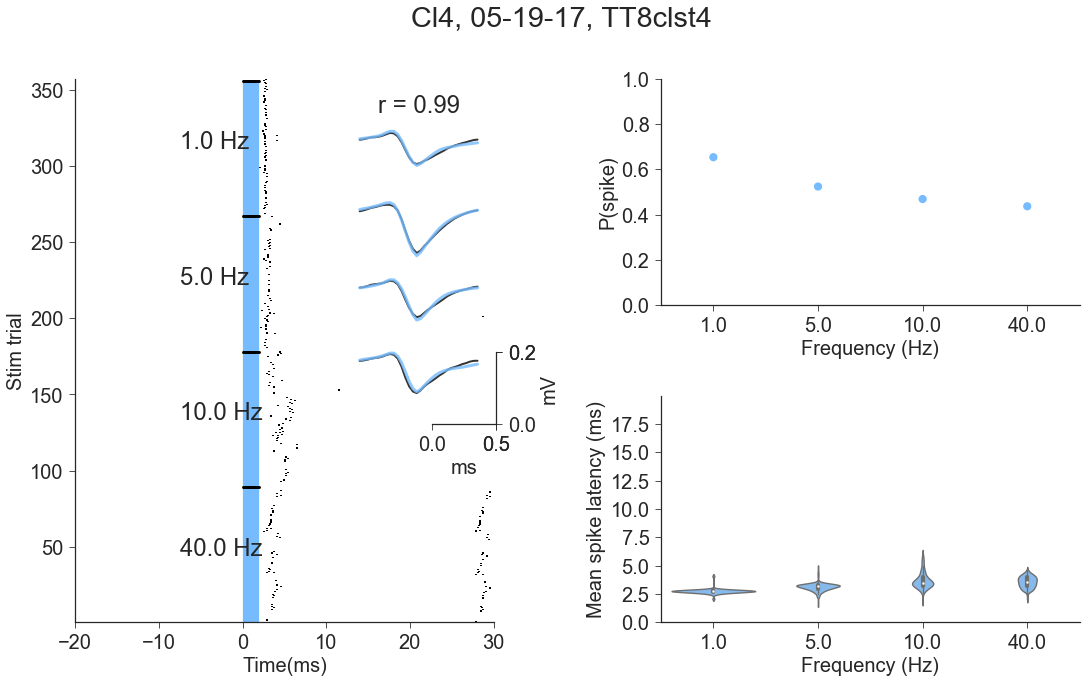

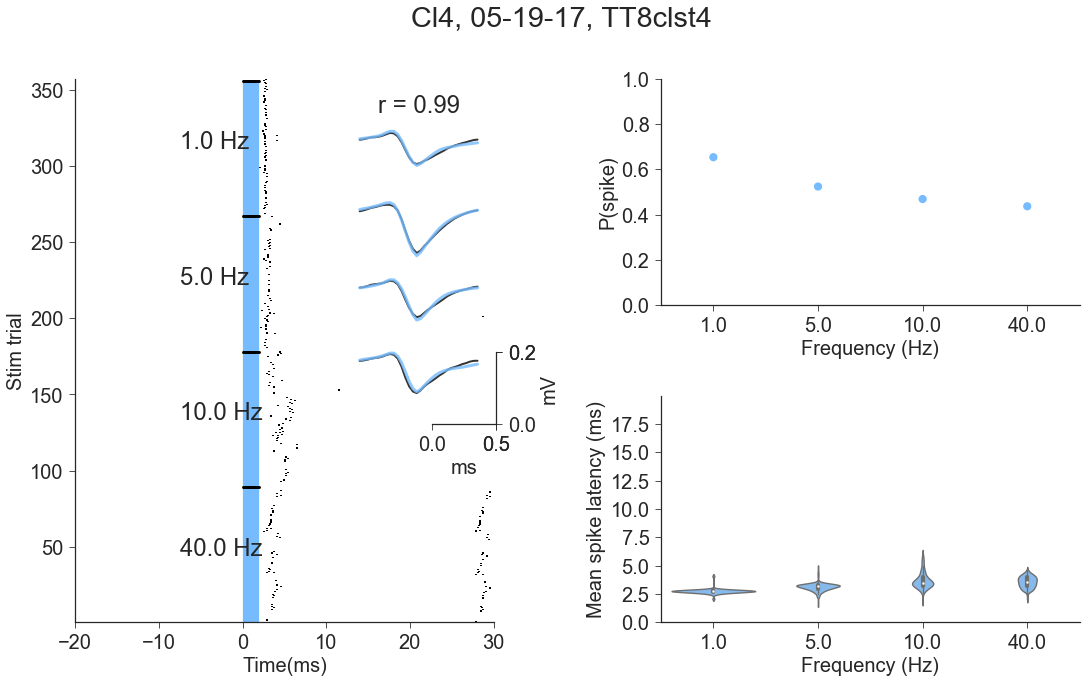

In [42]:
opto_metrics(24, opto_log_df, all_opto_metrics_df)

In [25]:
%autoreload 2

subset_dict = {}
size_dict = {}
subset_dict['None'] = 0
size_dict['None'] = 0

categories = np.concatenate([log_df['mouse_name'].unique(), log_df['identified'].unique()])

for cat in categories:
        subset = log_df[log_df['mouse_name'] == cat]
        if subset.size == 0:
            subset = log_df[log_df['identified'] == cat]
            print(cat)
        subset_dict[cat] = subset
        unique_units = subset[['mouse_name', 'date', 'cluster_name']].drop_duplicates()
        size_dict[cat] = len(unique_units)
        #print(unique_units.size)

unidentified


In [28]:
%load_ext autoreload
%autoreload 2
%timeit
%cd C:\Users\PC\Documents\GitHub\Claustrum_analysis
import ind_unit as iu
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.html import widgets
from IPython.display import display
import traitlets
from plotly.widgets import GraphWidget



w = widgets.Dropdown(options = list(subset_dict.keys()), value = 'unidentified', description='cellType:')
a = widgets.Dropdown(options = {'stimulus': 'spike_times(stim_aligned)',
                                'first lick': 'spike_times(lick_aligned)',
                               'last lick': 'spike_times(last_lick_aligned)'}, 
                                value = 'spike_times(stim_aligned)', description='align spikes to:')

num = widgets.IntSlider(min = 0, max = 50, step = 1, width='75%', height='30px', 
                    description= "Unit", continuous_update=False)
x1 = widgets.FloatSlider(min = -2, max = 0, step = 0.05, value = -0.25,width='75%',
                          height='30px', description= "xMin", continuous_update=False)
x2 = widgets.FloatSlider(min = 0, max = 5, step = 0.05, value=0.75,width='75%', height='30px',
                          description= "xMax",continuous_update=False)
s = interactive(iu.plot_unit, df_dict = fixed(subset_dict), s_key = w, alignment = a,
                n=num, x_min = x1, x_max = x2, continuous_update=False)


def update_max(*args):
    num.value = 1
    num.max = size_dict[w.value]                                
                            
w.observe(update_max, 'value')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\PC\Documents\GitHub\Claustrum_analysis


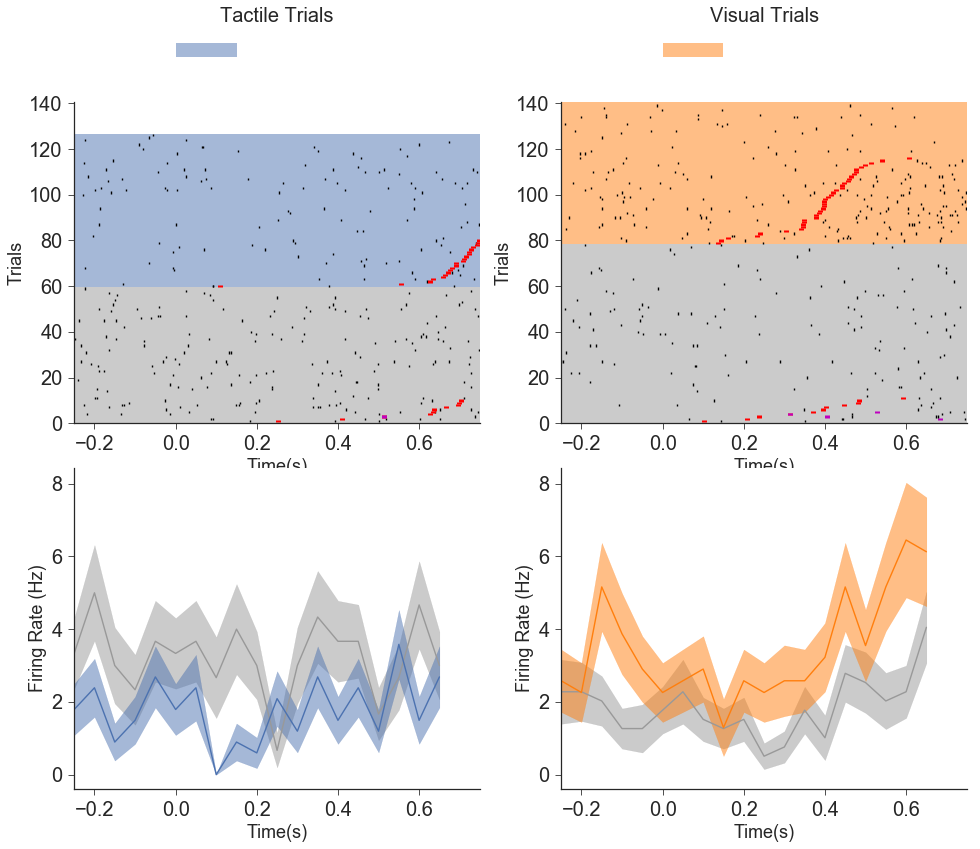

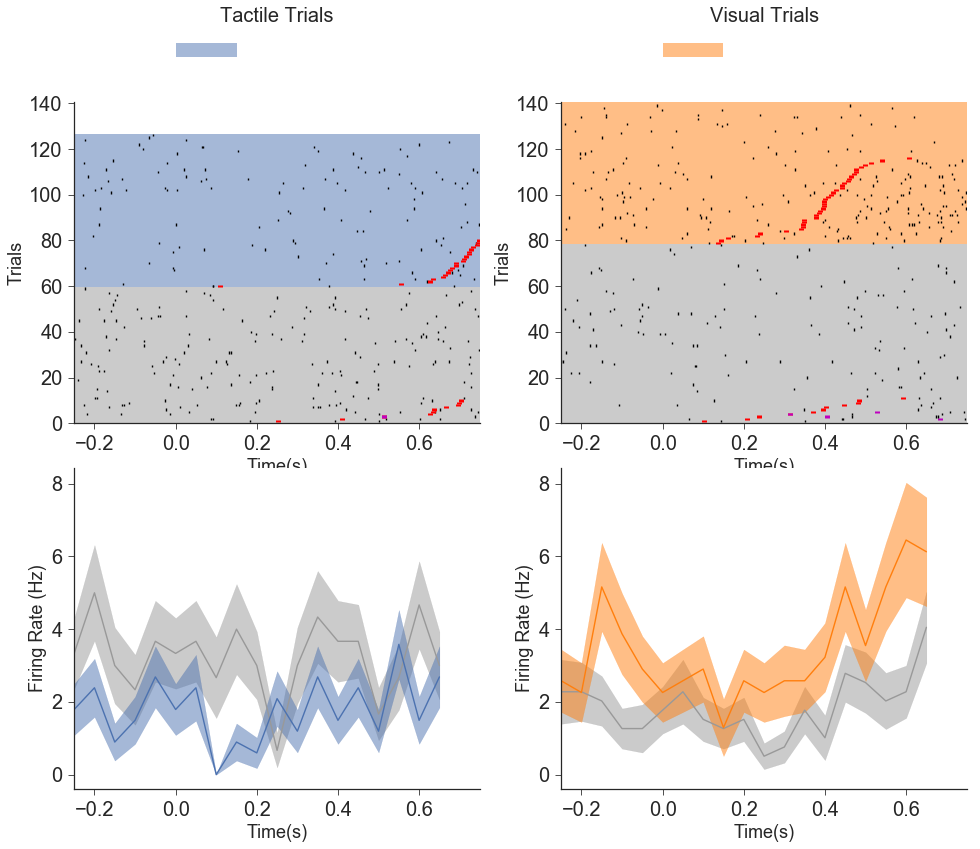

In [29]:
s

In [ ]:
mpl.savefig('psth_example.pdf',format='pdf', dpi=1200)